In [1]:
#import os
#
#if os.path.basename(os.getcwd()) != 'coli_phage_interactions_2023':
#  if not os.path.exists('coli_phage_interactions_2023'):
#    !git clone https://github.com/theafox/coli_phage_interactions_2023.git
#  %cd coli_phage_interactions_2023
#if not os.path.exists('data/fasta_files/fasta.zip'):
#  !cat data/fasta_files/*zip_part* > data/fasta_files/fasta.zip
#  !unzip data/fasta_files/fasta.zip -d data/fasta_files/

# Host-Phage Interaction Prediction: Reproduction of Research Results
This notebook reproduces the main results of the referenced research paper on host-phage interaction prediction. It covers data loading, preprocessing, feature engineering, model training, evaluation, and result visualization.

## 1. Data Loading
We begin by loading the interaction matrix, phage features, and bacteria (host) features from the provided CSV files.


In [2]:
import numpy as np
import pandas as pd

# Define data paths
host_path = 'data/genomics/bacteria/picard_collection.csv'
phage_path = 'data/genomics/phages/guelin_collection.csv'
embeddings_path = 'data/genomics/bacteria/umap_phylogeny/coli_umap_8_dims.tsv'
interaction_path = 'data/interactions/interaction_matrix.csv'

# Load data
hosts_df = pd.read_csv(host_path, index_col=0, sep=';')
phages_df = pd.read_csv(phage_path, index_col=0, sep=';')
embeddings_df = pd.read_csv(embeddings_path, index_col=0, sep='\t')
interactions_df = pd.read_csv(interaction_path, index_col=0, sep=';')

print(f"       Hosts: {hosts_df.shape}")
print(f"      Phages: {phages_df.shape}")
print(f"  Embeddings: {embeddings_df.shape}")
print(f"Interactions: {interactions_df.shape}")
display(hosts_df.head())
display(phages_df.head())
display(embeddings_df.head())
display(interactions_df.head())

       Hosts: (403, 20)
      Phages: (96, 10)
  Embeddings: (404, 8)
Interactions: (402, 96)


,Gembase,Host,Origin,Pathotype,Clermont_Phylo,ST_Warwick,O-type,H-type,Mouse_killed_10,Capsule_ABC,Capsule_GroupIV_e,Capsule_GroupIV_e_stricte,Capsule_GroupIV_s,Capsule_Wzy_stricte,LPS_type,Collection,Klebs_capsule_type,n_defense_systems,n_infections,ABC_serotype
bacteria,,,,,,,,,,,,,,,,,,,,
001-023,ESCO.0622.00103,Human,Faeces,Commensal,G,1163,O149,H23,0.0,0.0,0.0,1.0,1.0,1.0,R4,Original,NaN,9.0,32,NaN
001-031-c1,ESCO.0622.00308,Human,Faeces,Commensal,B2,452,O81,H27,0.0,1.0,0.0,0.0,1.0,1.0,R3,Original,NaN,8.0,5,Unknown
003-026,ESCO.0622.00119,Human,Faeces,Commensal,G,1163,O33,H23,0.0,0.0,0.0,1.0,1.0,1.0,R4,Original,NaN,6.0,28,NaN
013-008,ESCO.0622.00326,Human,Faeces,Commensal,B2,452,O81,H27,0.0,1.0,0.0,0.0,1.0,1.0,R3,Original,NaN,6.0,5,Unknown
025-010,ESCO.0622.00213,Human,Faeces,Commensal,E,543,O169,H9,0.0,0.0,0.0,1.0,1.0,0.0,R4,Original,NaN,10.0,30,NaN


,Morphotype,Family,Genus,Species,Genome_size,Phage_host,Phage_host_phylo,Old_Family,Subfamily,Old_Genus
phage,,,,,,,,,,
409_P1,Podoviridae,Autographiviridae,Kayfunavirus,Kayfunavirus ZG49,40079,PDP21,D,Autographiviridae,Studiervirinae,Kayfunavirus
409_P3,Podoviridae,Autographiviridae,Vectrevirus,Vectrevirus VEc3,45588,PDP21,D,Autographiviridae,Molineuxvirinae,Vectrevirus
409_P5,Podoviridae,Autographiviridae,Vectrevirus,Vectrevirus VEc3,45588,PDP21,D,Autographiviridae,Molineuxvirinae,Vectrevirus
409_P6,Podoviridae,Autographiviridae,Vectrevirus,Vectrevirus VEc3,44789,PDP21,D,Autographiviridae,Molineuxvirinae,Vectrevirus
409_P8,Siphoviridae,Other,Kagunavirus,Kagunavirus K1G,43594,PDP21,D,Siphoviridae,Guernseyvirinae,Kagunavirus


,UMAP0,UMAP1,UMAP2,UMAP3,UMAP4,UMAP5,UMAP6,UMAP7
bacteria,,,,,,,,
ECOR-12,14.809212,4.479959,6.614325,7.403806,5.942172,6.080655,4.733537,5.059260
IAI14,14.923162,4.349688,6.830584,7.355976,5.845553,6.122035,4.627062,4.886468
ECOR-25,14.655961,4.416495,6.713003,7.468843,5.975815,6.118094,4.856316,5.061173
IAI19,14.602400,4.480703,6.806061,7.532146,5.790100,6.129730,4.641324,5.032660
IAI20,14.739294,4.473202,6.754572,7.448086,5.855868,6.016634,4.707124,4.993468


,55989_P2,LF82_P8,AL505_Ev3,LF73_P4,BCH953_P2,BCH953_P4,BCH953_P5,LF73_P1,LF73_P3,NIC06_P2,...,LM08_P2,NRG_12A1B,411_P1,536_P12,BDX09_P1,411_P2,LF50_P3,LM40_P1,LM40_P2,LM40_P3
bacteria,,,,,,,,,,,,,,,,,,,,,
ECOR-54,0.0,1.0,0.0,1.0,1.0,0.0,0.0,4.0,4.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DIJ06,0.0,1.0,0.0,2.0,0.0,0.0,0.0,4.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ECOR-52,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ECOR-51,3.0,2.0,2.0,3.0,3.0,4.0,4.0,3.0,3.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
ECOR-55,2.0,3.0,1.0,4.0,0.0,2.0,1.0,3.0,4.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


## 2. Data Preprocessing
We preprocess the data by aligning indices, handling missing values, and ensuring all datasets are compatible for merging and modeling.

In [3]:
# Handle missing values
hosts_df = hosts_df.fillna(hosts_df.median(numeric_only=True))
phages_df = phages_df.fillna(phages_df.median(numeric_only=True))

for df in [phages_df, hosts_df]:
    for col in df.select_dtypes(include=['object', 'category']).columns:
        if df[col].isna().sum() > 0:
            df[col] = df[col].fillna('Other')

interactions_df = interactions_df.dropna(axis=0, how='any')
interactions_df = interactions_df.dropna(axis=1, how='any')

# Convert categorical columns to 'category' dtype
for df in [phages_df, hosts_df]:
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype('category')

print(f"Filtered Interactions: {interactions_df.shape}")

Filtered Interactions: (387, 96)


## 3. Feature Engineering
We construct the feature matrix for each host-phage pair by concatenating phage and host features. The target is the interaction (1/0) from the matrix.

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

FEATURE_MIN_ROWS = 5  # minimum number of rows required per categorical feature
INCLUDED_HOST_FEATURES = ('ST_Warwick', 'O-type', 'H-type')

# Convert interaction matrix to binary (1 = any interaction, 0 = no interaction)
interactions_df = (interactions_df > 0).astype(int)

# Add embeddings to the hosts
hosts_df = pd.merge(embeddings_df, hosts_df, left_index=True, right_index=True)

# Reduce feature complexity by recoding rare categories.
for feature in ('O-type', 'ST_Warwick'):
    to_recode = hosts_df.groupby(feature, observed=False).filter(lambda rows: len(rows) < FEATURE_MIN_ROWS)[feature].unique()
    if 'Other' not in hosts_df[feature].cat.categories:
        hosts_df[feature] = hosts_df[feature].cat.add_categories(['Other'])
    hosts_df.loc[hosts_df[feature].isin(to_recode), feature] = 'Other'

# Add data of their respective host to the phages; and remove some features
if 'Phage_host' in phages_df.columns:
    phages_df = pd.merge(
        phages_df,
        hosts_df.filter(regex=rf"({'|'.join(INCLUDED_HOST_FEATURES)})", axis=1),
        left_on="Phage_host",
        right_on="bacteria",
        right_index=True,
    ).rename({feature: f"{feature}_host" for feature in INCLUDED_HOST_FEATURES}, axis=1)
phages_df = phages_df.filter(regex=r"(Morphotype|Genus|Phage_host)")
hosts_df = hosts_df.filter(regex=r"(UMAP|O-type|LPS|ST_Warwick|Klebs|ABC_serotype)")

# Align indices and filter to common phages/hosts
common_hosts = interactions_df.index.intersection(hosts_df.index)
common_phages = interactions_df.columns.intersection(phages_df.index)

hosts_df = hosts_df.loc[common_hosts.tolist()]
phages_df = phages_df.loc[common_phages.tolist()]
interactions_df = interactions_df.loc[common_hosts.tolist(), common_phages.tolist()]

# Build feature matrix and target vector
X = []
y = []
phage_ids = []
host_ids = []

for host in interactions_df.index:
    for phage in interactions_df.columns:
        X.append(np.concatenate([hosts_df.loc[host], phages_df.loc[phage]]))
        y.append(interactions_df.loc[host, phage])
        phage_ids.append(phage)
        host_ids.append(host)

X, y = np.array(X), np.array(y)

# Encode categorical features and scale numeric ones
categorical_indices = [i for i, v in enumerate(X[0]) if isinstance(v, str)]
numeric_indices = [i for i in range(len(X[0])) if i not in categorical_indices]

encoder = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_indices),
        ('cat', OneHotEncoder(sparse_output=False), categorical_indices),
    ]
)
X = encoder.fit_transform(X)

# Split the data into training and testing sets
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Feature matrix shape: {X.shape}")
print(f" Target vector shape: {y.shape}")

Feature matrix shape: (28483, 162)
 Target vector shape: (28483,)


## 4. Model Training and Cross-Validation
We train a Random Forest classifier and evaluate it using stratified 5-fold cross-validation. We also compare with a Logistic Regression and a DummyClassifier (baseline).

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tqdm.notebook import tqdm

# Metrics, class weights, and models
metrics = ('accuracy', 'f1', 'roc_auc')
perc_pos_class = np.sum(y) / len(y)
if 0.60 <= perc_pos_class:
    cw = {0: 1, 1: 0.8}
elif 0.4 <= perc_pos_class < 0.6:
    cw = {0: 1, 1: 1}
elif 0.3 <= perc_pos_class < 0.4:
    cw = {0: 1, 1: 1.5}
elif 0.2 <= perc_pos_class < 0.3:
    cw = {0: 1, 1: 2}
else:
    cw = {0: 1, 1: 3}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = {
    'Dummy': DummyClassifier(strategy='most_frequent'),
    'Logistic Regression L1': LogisticRegression(penalty='l1', solver='saga', max_iter=10_000, class_weight=cw, random_state=42),
    'Logistic Regression L2': LogisticRegression(max_iter=10_000, class_weight=cw, random_state=42),
    'Random Forest D3': RandomForestClassifier(n_estimators=250, max_depth=3, class_weight=cw, random_state=42),
    'Random Forest D6': RandomForestClassifier(n_estimators=250, max_depth=6, class_weight=cw, random_state=42),
}

# Training and Evaluation (cross-validation)
results = []
for name, model in tqdm(models.items(), desc="Training and Evaluation", unit='model(s)'):
    scores = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=metrics,
        return_train_score=True,
        return_estimator=True,
    )
    for fold in range(len(list(scores.values())[0])):
        results.append({
            'model_name': name,
            'fold': fold + 1,
            **{k.replace('test_', 'val_'): v[fold] for k, v in scores.items()},
        })
        for metric in metrics:
            match metric:
                case 'accuracy':
                    results[-1][f'test_{metric}'] = accuracy_score(y_test, scores['estimator'][fold].predict(X_test))
                case 'f1':
                    results[-1][f'test_{metric}'] = f1_score(y_test, scores['estimator'][fold].predict(X_test))
                case 'roc_auc':
                    results[-1][f'test_{metric}'] = roc_auc_score(y_test, scores['estimator'][fold].predict(X_test))
                case _:
                    raise RuntimeError('Unknown metric specified')
results_df = pd.DataFrame(results).set_index(['model_name', 'fold'])

for i, (name, row) in enumerate(results_df.drop(columns=['estimator']).groupby('model_name').agg(['mean', 'std']).iterrows()):
    if i != 0:
        print()
    print(f"{name} Model Scores:")
    for metric in metrics:
        print(f"  Training {metric.replace('_', ' ').upper():>8} Score: {row[f'train_{metric}']['mean']:.03f}±{row[f'train_{metric}']['std']:.03f}", end='  ')
        print(f"  Validation {metric.replace('_', ' ').upper():>8} Score: {row[f'val_{metric}']['mean']:.03f}±{row[f'val_{metric}']['std']:.03f}", end='  ')
        print(f"  Testing {metric.replace('_', ' ').upper():>8} Score: {row[f'test_{metric}']['mean']:.03f}±{row[f'test_{metric}']['std']:.03f}")

Training and Evaluation:   0%|          | 0/5 [00:00<?, ?model(s)/s]

Dummy Model Scores:
  Training ACCURACY Score: 0.799±0.000    Validation ACCURACY Score: 0.799±0.000    Testing ACCURACY Score: 0.801±0.000
  Training       F1 Score: 0.000±0.000    Validation       F1 Score: 0.000±0.000    Testing       F1 Score: 0.000±0.000
  Training  ROC AUC Score: 0.500±0.000    Validation  ROC AUC Score: 0.500±0.000    Testing  ROC AUC Score: 0.500±0.000

Logistic Regression L1 Model Scores:
  Training ACCURACY Score: 0.812±0.001    Validation ACCURACY Score: 0.809±0.003    Testing ACCURACY Score: 0.824±0.002
  Training       F1 Score: 0.552±0.002    Validation       F1 Score: 0.545±0.007    Testing       F1 Score: 0.576±0.004
  Training  ROC AUC Score: 0.840±0.001    Validation  ROC AUC Score: 0.834±0.002    Testing  ROC AUC Score: 0.741±0.002

Logistic Regression L2 Model Scores:
  Training ACCURACY Score: 0.812±0.002    Validation ACCURACY Score: 0.809±0.003    Testing ACCURACY Score: 0.824±0.001
  Training       F1 Score: 0.551±0.003    Validation       F1 Sc

## 5. Feature Importance (Random Forest)
We examine the most important features as determined by the Random Forest model.

In [6]:
# Fit Random Forest on all data for feature importances
importances = results_df.loc["Random Forest D6"]["estimator"].iloc[0].feature_importances_
feature_names = encoder.get_feature_names_out()

# Top 10 features
importances_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importances_df = importances_df.sort_values('importance', ascending=False).head(10)
display(importances_df)

,feature,importance
84,cat__x13_Myoviridae,0.171199
85,cat__x13_Podoviridae,0.070178
86,cat__x13_Siphoviridae,0.042556
122,cat__x15_LF82,0.041841
3,num__x3,0.036619
82,cat__x12_Other,0.035293
89,cat__x14_Felixounavirus,0.032231
154,cat__x17_Phapecoctavirus,0.030720
73,cat__x12_K1,0.030719
147,cat__x17_Felixounavirus,0.027840


## 6. Visualization of Results
We visualize model performance and feature importances.

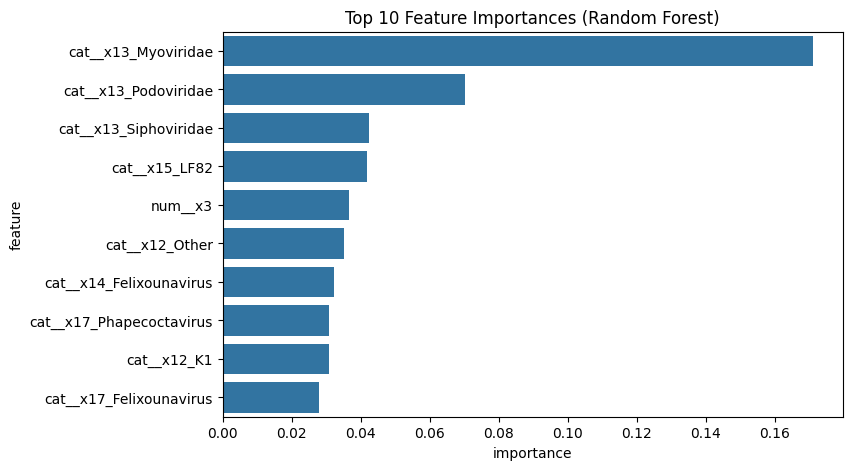

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importances
plt.figure(figsize=(8, 5))
graph = sns.barplot(x='importance', y='feature', data=importances_df)
graph.set_title('Top 10 Feature Importances (Random Forest)')#
plt.show()

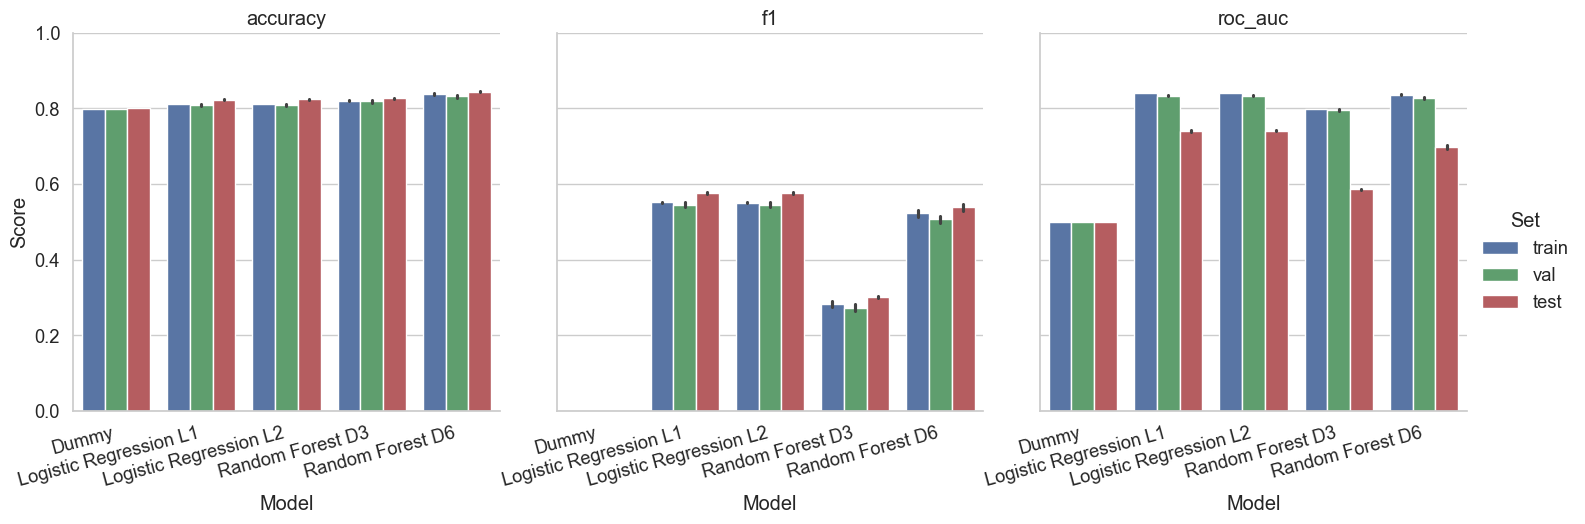

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plot_df = pd.melt(
    results_df.reset_index(),
    id_vars=('model_name',),
    value_vars=[column for column in results_df.columns if column.startswith(('train_', 'val_', 'test_'))],
    var_name='set_metric',
    value_name='score'
)
plot_df['set'] = pd.Categorical(plot_df['set_metric'].str.extract(r'^(train|val|test)_')[0], categories=('train', 'val', 'test'), ordered=True)
plot_df['metric'] = plot_df['set_metric'].str.extract(rf'_({"|".join(metrics)})$').astype('category')
plot_df = plot_df.drop(columns=['set_metric'])

# Improve plot style for presentation
sns.set_theme(style="whitegrid", font_scale=1.2)
palette = {"train": "#4C72B0", "val": "#55A868", "test": "#C44E52"}

graph = sns.catplot(
    data=plot_df,
    kind='bar',
    x='model_name',
    y='score',
    hue='set',
    col='metric',
    palette=palette,
)

graph.set_titles('{col_name}').set_axis_labels('Model', 'Score').set_xticklabels(rotation=15, horizontalalignment='right')
for ax in graph.axes[0]:
    ax.set_ylim(0, 1)
graph._legend.set_title("Set")
plt.show()

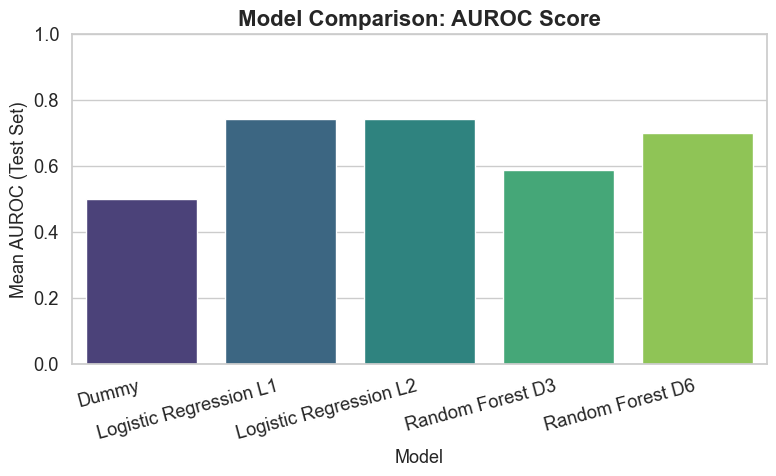

In [16]:
# Plot AUROC scores for each model (presentation style)
plt.figure(figsize=(8, 5))
sns.set_theme(style="whitegrid", font_scale=1.2)

auroc_means = results_df.groupby('model_name')['test_roc_auc'].mean().reset_index()
auroc_stds = results_df.groupby('model_name')['test_roc_auc'].std().reset_index()
auroc_means = auroc_means.merge(auroc_stds, on='model_name', suffixes=('_mean', '_std'))

ax = sns.barplot(
    data=auroc_means,
    x='model_name',
    y='test_roc_auc_mean',
    hue='model_name', # Assign x to hue
    legend=False,    # Set legend to False
    #yerr=auroc_means['test_roc_auc_std'],
    palette='viridis'
)
ax.set_title('Model Comparison: AUROC Score', fontsize=16, weight='bold')
ax.set_xlabel('Model', fontsize=13)
ax.set_ylabel('Mean AUROC (Test Set)', fontsize=13)
ax.set_ylim(0, 1)
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

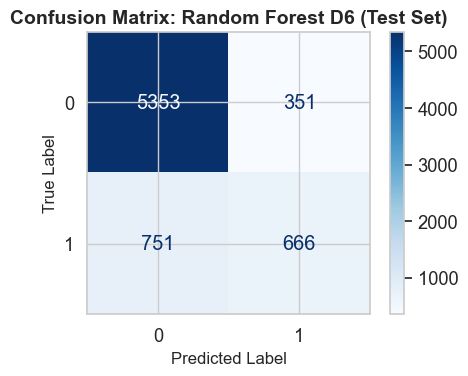

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix for the best Random Forest D6 model on the test set
best_rf = results_df.loc["Random Forest D6"]["estimator"].iloc[0]
y_pred = best_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(5, 4))
sns.set_theme(style="whitegrid", font_scale=1.2)
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title("Confusion Matrix: Random Forest D6 (Test Set)", fontsize=14, weight='bold')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()

## Add new models

In [11]:
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

models['LightGBM'] = LGBMClassifier(class_weight=cw, random_state=42)
models['SVM'] = SVC(kernel='linear', class_weight=cw, random_state=42)

## Implement hyperparameter tuning

In [12]:
param_grids = {
    'Dummy': {},
    'Logistic Regression L1': {'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    'Logistic Regression L2': {'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    'Random Forest D3': {'n_estimators': [100, 200, 300], 'max_depth': [2, 3, 4], 'min_samples_split': [2, 5, 10]},
    'Random Forest D6': {'n_estimators': [100, 200, 300], 'max_depth': [5, 6, 7], 'min_samples_split': [2, 5, 10]},
    'LightGBM': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.5], 'num_leaves': [31, 63, 127]},
    'SVM': {'C': [0.001, 0.01, 0.1, 1, 10, 100]},
}

In [13]:
import os
import pickle
from glob import glob
from sklearn.model_selection import GridSearchCV
from tqdm.notebook import tqdm

tuned_models = {}
for name, model in tqdm(models.items(), desc="Hyperparameter Tuning", unit='model'):
    if os.path.exists(f'{name}_model.pkl'):
        with open(f'{name}_model.pkl', 'rb') as file:
            tuned_models[name] = pickle.load(file)
        print(f"Using cached {name}")
    elif name in param_grids and param_grids[name]: # Check if parameter grid exists and is not empty
        grid_search = GridSearchCV(model, param_grid=param_grids[name], cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
        grid_search.fit(X, y)
        tuned_models[name] = grid_search.best_estimator_
        with open(f'{name}_model.pkl', 'wb') as file:
            pickle.dump(tuned_models[name], file) # Save the tuned model, not the original
        print(f"Best parameters for {name}: {grid_search.best_params_}")
        print(f"Best ROC AUC score for {name}: {grid_search.best_score_}")
    else:
        tuned_models[name] = model # Use the default model if no tuning is specified
        print(f"No tuning for {name}, using default model.")

Hyperparameter Tuning:   0%|          | 0/7 [00:00<?, ?model/s]

No tuning for Dummy, using default model.
Using cached Logistic Regression L1
Using cached Logistic Regression L2
Using cached Random Forest D3
Using cached Random Forest D6
Using cached LightGBM
Using cached SVM


## Evaluate tuned models

In [17]:
from sklearn.metrics import precision_score, recall_score

# Add precision and recall to metrics
metrics_extended = ('accuracy', 'f1', 'roc_auc', 'precision', 'recall')

# Re-evaluate tuned models with extended metrics
results_extended = []
for name, model in tqdm(tuned_models.items(), desc="Evaluation of Tuned Models (Extended Metrics)", unit='model(s)'):
    scores = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=metrics_extended,
        return_train_score=True,
        return_estimator=True,
    )
    for fold in range(len(list(scores.values())[0])):
        results_extended.append({
            'model_name': name,
            'fold': fold + 1,
            **{k.replace('test_', 'val_'): v[fold] for k, v in scores.items()},
        })
        for metric in metrics_extended:
            match metric:
                case 'accuracy':
                    results_extended[-1][f'test_{metric}'] = accuracy_score(y_test, scores['estimator'][fold].predict(X_test))
                case 'f1':
                    results_extended[-1][f'test_{metric}'] = f1_score(y_test, scores['estimator'][fold].predict(X_test))
                case 'roc_auc':
                    results_extended[-1][f'test_{metric}'] = roc_auc_score(y_test, scores['estimator'][fold].predict(X_test))
                case 'precision':
                    results_extended[-1][f'test_{metric}'] = precision_score(y_test, scores['estimator'][fold].predict(X_test))
                case 'recall':
                    results_extended[-1][f'test_{metric}'] = recall_score(y_test, scores['estimator'][fold].predict(X_test))
                case _:
                    raise RuntimeError('Unknown metric specified')
results_df_tuned_extended = pd.DataFrame(results_extended).set_index(['model_name', 'fold'])

# Print summary of extended metrics
for i, (name, row) in enumerate(results_df_tuned_extended.drop(columns=['estimator']).groupby('model_name').agg(['mean', 'std']).iterrows()):
    if i != 0:
        print()
    print(f"{name} Model Scores:")
    for metric in metrics_extended:
        print(f"  Training {metric.replace('_', ' ').upper():>9} Score: {row[f'train_{metric}']['mean']:.03f}±{row[f'train_{metric}']['std']:.03f}", end='  ')
        print(f"  Validation {metric.replace('_', ' ').upper():>9} Score: {row[f'val_{metric}']['mean']:.03f}±{row[f'val_{metric}']['std']:.03f}", end='  ')
        print(f"  Testing {metric.replace('_', ' ').upper():>9} Score: {row[f'test_{metric}']['mean']:.03f}±{row[f'test_{metric}']['std']:.03f}")


Evaluation of Tuned Models (Extended Metrics):   0%|          | 0/7 [00:00<?, ?model(s)/s]

Dummy Model Scores:
  Training  ACCURACY Score: 0.799±0.000    Validation  ACCURACY Score: 0.799±0.000    Testing  ACCURACY Score: 0.801±0.000
  Training        F1 Score: 0.000±0.000    Validation        F1 Score: 0.000±0.000    Testing        F1 Score: 0.000±0.000
  Training   ROC AUC Score: 0.500±0.000    Validation   ROC AUC Score: 0.500±0.000    Testing   ROC AUC Score: 0.500±0.000
  Training PRECISION Score: 0.000±0.000    Validation PRECISION Score: 0.000±0.000    Testing PRECISION Score: 0.000±0.000
  Training    RECALL Score: 0.000±0.000    Validation    RECALL Score: 0.000±0.000    Testing    RECALL Score: 0.000±0.000

LightGBM Model Scores:
  Training  ACCURACY Score: 0.957±0.001    Validation  ACCURACY Score: 0.887±0.005    Testing  ACCURACY Score: 0.891±0.002
  Training        F1 Score: 0.899±0.002    Validation        F1 Score: 0.731±0.010    Testing        F1 Score: 0.737±0.004
  Training   ROC AUC Score: 0.992±0.000    Validation   ROC AUC Score: 0.932±0.003    Testing  

In [ ]:
print("Comparison of Tuned Models vs Original Models (Mean Test Set Scores):")
comparison_df = pd.concat([
    results_df.drop(columns=['estimator']).groupby('model_name').agg('mean'),
    results_df_tuned_extended.drop(columns=['estimator']).groupby('model_name').agg('mean')
], keys=['Original', 'Tuned'])
display(comparison_df.unstack(level=0)[['test_accuracy', 'test_f1', 'test_roc_auc']])

Comparison of Tuned Models vs Original Models (Mean Test Set Scores):


test_accuracy             test_f1            \
                            Original     Tuned  Original     Tuned   
model_name                                                           
Dummy                       0.801011  0.801011  0.000000  0.000000   
LightGBM                         NaN  0.891279       NaN  0.737409   
Logistic Regression L1      0.823564  0.823564  0.576116  0.576116   
Logistic Regression L2      0.824070  0.824070  0.576701  0.576701   
Random Forest D3            0.826766  0.837916  0.300511  0.439957   
Random Forest D6            0.844713  0.846482  0.539447  0.563931   
SVM                              NaN  0.805701       NaN  0.534180   

                       test_roc_auc            
                           Original     Tuned  
model_name                                     
Dummy                      0.500000  0.500000  
LightGBM                        NaN  0.844619  
Logistic Regression L1     0.740506  0.740506  
Logistic Regression L2     0.740715  0.740715  
Random Forest D3           0.586355  0.643278  
Random Forest D6           0.699129  0.715827  
SVM                             NaN  0.713338

## Visualization

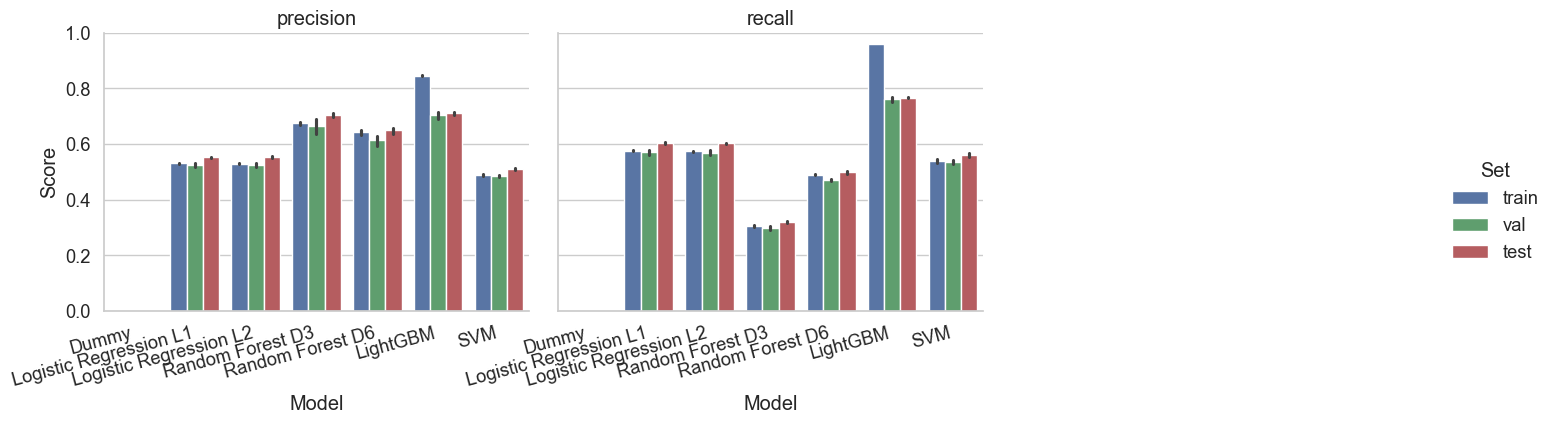

In [27]:
# Visualize performance of tuned models
plot_df_tuned = pd.melt(
    results_df_tuned_extended.reset_index(),
    id_vars=('model_name',),
    value_vars=[column for column in results_df_tuned_extended.columns if column.startswith(('train_', 'val_', 'test_')) and ('precision' in column or 'recall' in column)],
    var_name='set_metric',
    value_name='score'
)
plot_df_tuned['set'] = pd.Categorical(plot_df_tuned['set_metric'].str.extract(r'^(train|val|test)_')[0], categories=('train', 'val', 'test'), ordered=True)
plot_df_tuned['metric'] = plot_df_tuned['set_metric'].str.extract(rf'_({"|".join(metrics_extended)})$').astype('category')
plot_df_tuned = plot_df_tuned.drop(columns=['set_metric'])

graph = sns.catplot(
    data=plot_df_tuned,
    kind='bar',
    x='model_name',
    y='score',
    hue='set',
    col='metric',
    palette=palette,
    col_wrap=3,  # Adjust based on the number of metrics
    height=4,    # Adjust for better visualization
    aspect=1.2   # Adjust for better visualization
)

graph.set_titles('{col_name}').set_axis_labels('Model', 'Score').set_xticklabels(rotation=15, horizontalalignment='right')
for ax in graph.axes.flat:
    ax.set_ylim(0, 1)
graph._legend.set_title("Set")
plt.show()

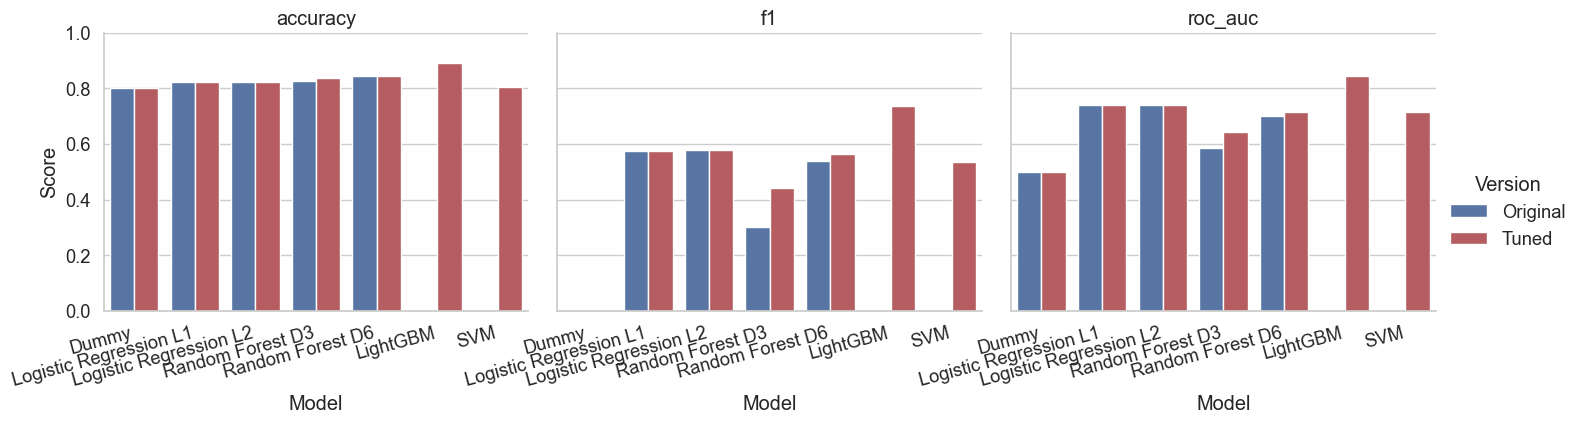

In [28]:
# Visualize comparison of tuned vs original models
comparison_plot_df = pd.melt(
    comparison_df.reset_index(),
    id_vars=('model_name', 'level_0'),
    value_vars=[column for column in comparison_df.columns if column.startswith('test_')],
    var_name='metric',
    value_name='score'
)
comparison_plot_df = comparison_plot_df.rename(columns={'level_0': 'version'})
comparison_plot_df['metric'] = comparison_plot_df['metric'].str.replace('test_', '')

graph = sns.catplot(
    data=comparison_plot_df,
    kind='bar',
    x='model_name',
    y='score',
    hue='version',
    col='metric',
    palette={'Original': '#4C72B0', 'Tuned': '#C44E52'}, # Adjust palette
    col_wrap=3,  # Adjust based on the number of metrics
    height=4,    # Adjust for better visualization
    aspect=1.2   # Adjust for better visualization
)

graph.set_titles('{col_name}').set_axis_labels('Model', 'Score').set_xticklabels(rotation=15, horizontalalignment='right')
for ax in graph.axes.flat:
    ax.set_ylim(0, 1)
graph._legend.set_title("Version")
plt.show()

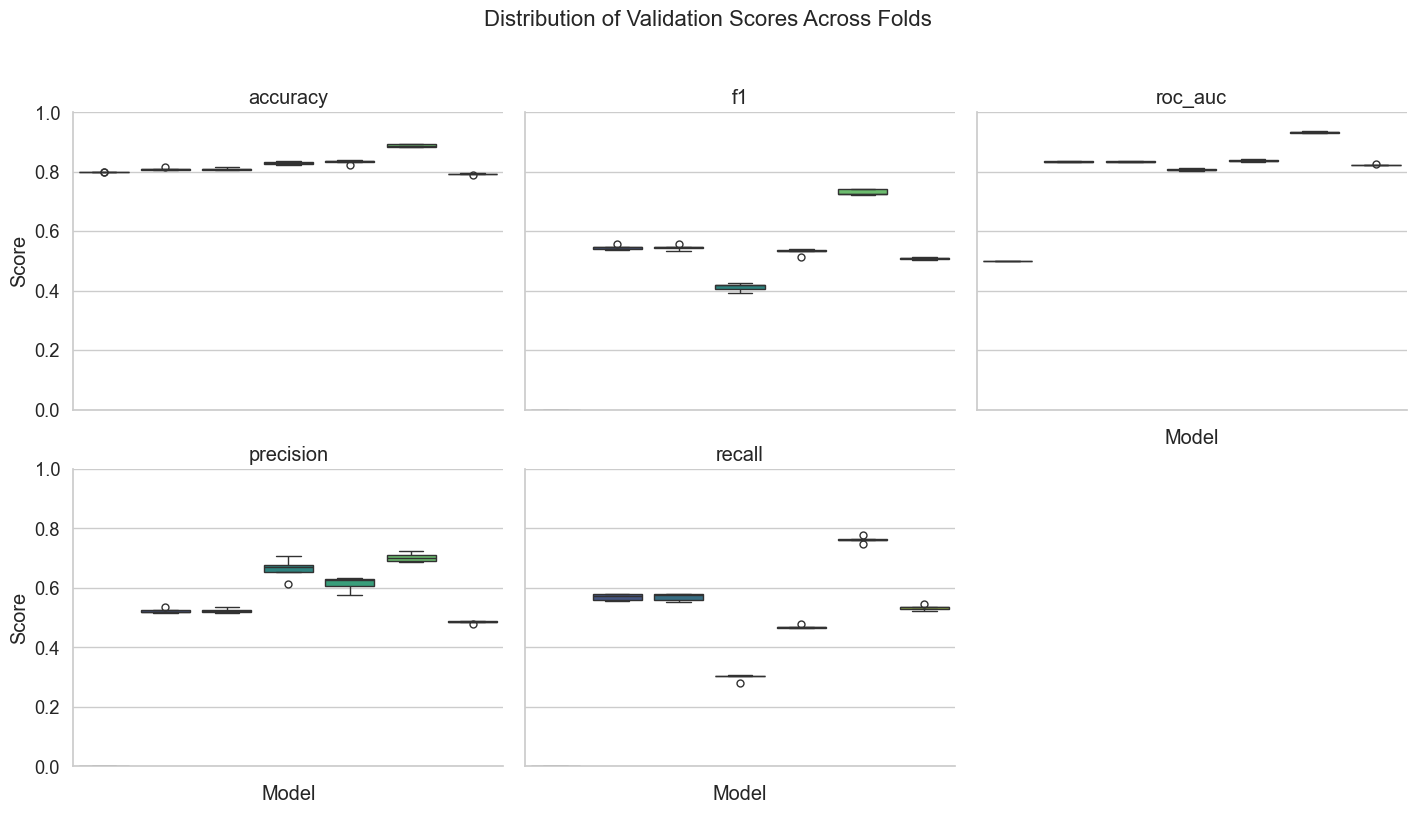

In [37]:
# Box plot of cross-validation results for each metric and model
plot_df_tuned_melted = pd.melt(
    results_df_tuned_extended.reset_index(),
    id_vars=('model_name', 'fold'),
    value_vars=[column for column in results_df_tuned_extended.columns if column.startswith('val_')],
    var_name='metric',
    value_name='score'
)
plot_df_tuned_melted['metric'] = plot_df_tuned_melted['metric'].str.replace('val_', '')

graph = sns.catplot(
    data=plot_df_tuned_melted,
    kind='box',
    x='model_name',
    y='score',
    col='metric',
    col_wrap=3,
    height=4,
    aspect=1.2,
    palette='viridis',
    hue=None # Explicitly set hue to None to avoid the warning
)
graph.set_titles('{col_name}').set_axis_labels('Model', 'Score').set_xticklabels(rotation=15, horizontalalignment='right')
for ax in graph.axes.flat:
    ax.set_ylim(0, 1)
graph.fig.suptitle('Distribution of Validation Scores Across Folds', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

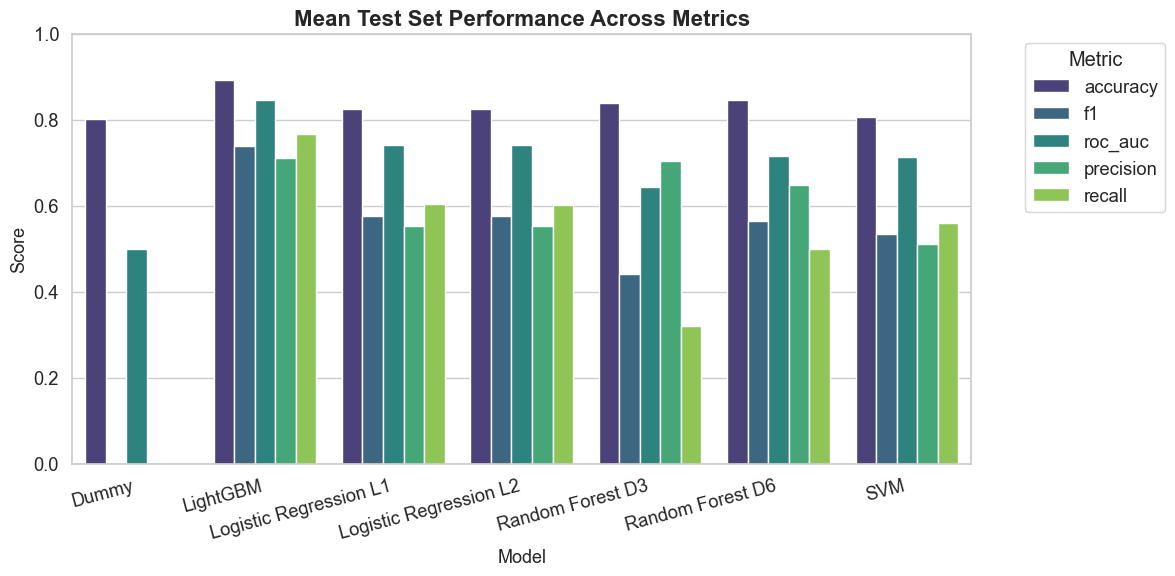

In [33]:
# Combined plot of test set performance across all metrics for each model
test_scores_df = results_df_tuned_extended.drop(columns=['estimator']).groupby('model_name').mean().reset_index()
test_scores_melted = pd.melt(
    test_scores_df,
    id_vars='model_name',
    value_vars=[column for column in test_scores_df.columns if column.startswith('test_')],
    var_name='metric',
    value_name='score'
)
test_scores_melted['metric'] = test_scores_melted['metric'].str.replace('test_', '')

plt.figure(figsize=(12, 6))
graph = sns.barplot(
    data=test_scores_melted,
    x='model_name',
    y='score',
    hue='metric',
    palette='viridis'
)
graph.set_title('Mean Test Set Performance Across Metrics', fontsize=16, weight='bold')
graph.set_xlabel('Model', fontsize=13)
graph.set_ylabel('Score', fontsize=13)
graph.set_ylim(0, 1)
plt.xticks(rotation=15, ha='right')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

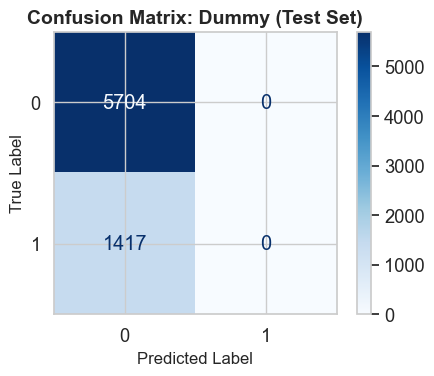

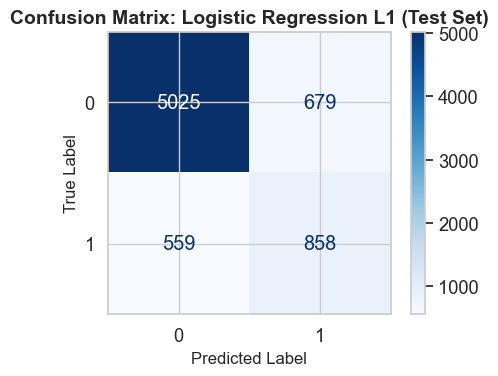

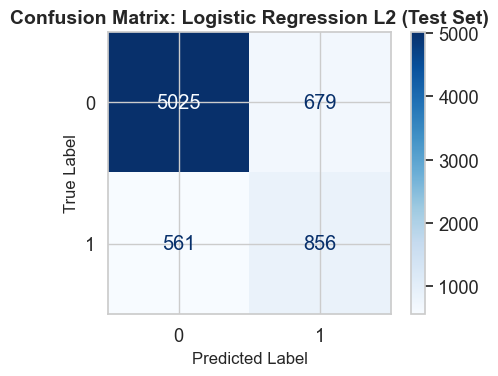

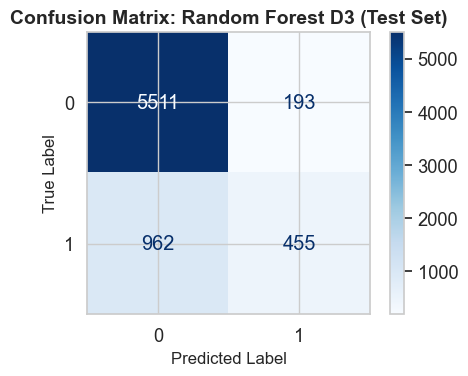

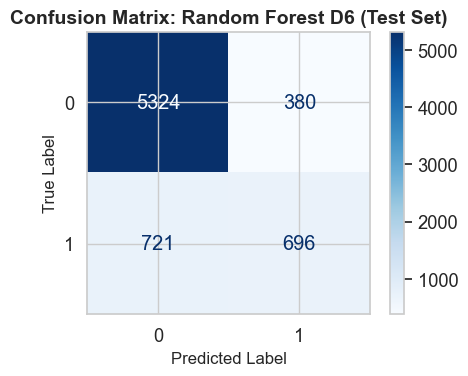

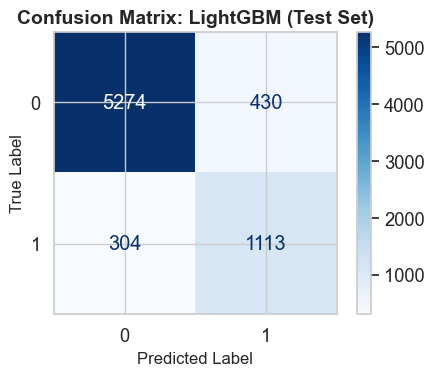

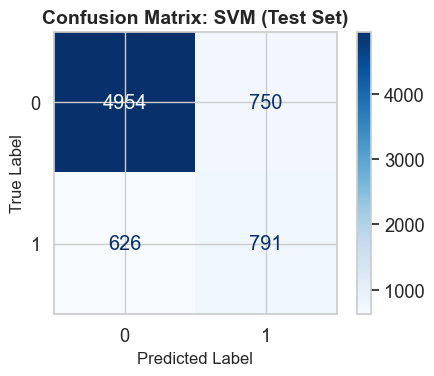

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Generate and plot confusion matrix for each tuned model on the test set
for name, model in tuned_models.items():
    # Fit the model if it's the DummyClassifier and hasn't been fitted yet
    if name == 'Dummy' and not hasattr(model, 'n_outputs_'):
        model.fit(X, y)

    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    plt.figure(figsize=(5, 4))
    sns.set_theme(style="whitegrid", font_scale=1.2)
    disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
    plt.title(f"Confusion Matrix: {name} (Test Set)", fontsize=14, weight='bold')
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.tight_layout()
    plt.show()

In [29]:
print("Tuned Models:")
for name, model in tuned_models.items():
    print(f"- {name}: {model}")

Tuned Models:
- Dummy: DummyClassifier(strategy='most_frequent')
- Logistic Regression L1: LogisticRegression(C=1, class_weight={0: 1, 1: 2}, max_iter=10000, penalty='l1',
                   random_state=42, solver='saga')
- Logistic Regression L2: LogisticRegression(C=1, class_weight={0: 1, 1: 2}, max_iter=10000,
                   random_state=42)
- Random Forest D3: RandomForestClassifier(class_weight={0: 1, 1: 2}, max_depth=4,
                       min_samples_split=10, n_estimators=300, random_state=42)
- Random Forest D6: RandomForestClassifier(class_weight={0: 1, 1: 2}, max_depth=7,
                       min_samples_split=5, n_estimators=200, random_state=42)
- LightGBM: LGBMClassifier(class_weight={0: 1, 1: 2}, n_estimators=200, num_leaves=127,
               random_state=42)
- SVM: SVC(C=100, class_weight={0: 1, 1: 2}, kernel='linear', random_state=42)


In [40]:
for name, model in tuned_models.items():
    # Fit the model if it's the DummyClassifier and hasn't been fitted yet
    if name == 'Dummy' and not hasattr(model, 'n_outputs_'):
        model.fit(X, y)

    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    tn, fp, fn, tp = cm.ravel()

    print(f"\n--- {name} Confusion Matrix Interpretation ---")
    print(f"True Positives (TP): {tp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")

    print("\nPerformance Analysis:")
    if name == 'Dummy':
        print("Dummy Classifier (Baseline): This model predicts the most frequent class (negative).")
        print("It correctly identifies a large number of True Negatives but fails to identify any True Positives, resulting in all positive cases being False Negatives.")
        print("Precision and Recall are 0 for the positive class, as seen in previous metric outputs.")
    else:
        print(f"  - Correctly identified positive interactions (TP): {tp}")
        print(f"  - Correctly identified negative interactions (TN): {tn}")
        print(f"  - Incorrectly predicted positive interactions (FP): {fp}")
        print(f"  - Incorrectly predicted negative interactions (FN): {fn}")

        print("\nStrengths:")
        if tn > tp:
            print(f"  - Excellent at identifying negative interactions ({tn} TNs).")
        else:
             print(f"  - Excellent at identifying positive interactions ({tp} TPs).")

        print("\nWeaknesses:")
        if fn > fp:
            print(f"  - Struggles with identifying positive interactions (high FN count: {fn}).")
        else:
            print(f"  - Struggles with identifying negative interactions (high FP count: {fp}).")

    print("\nImplications of Errors:")
    print(f"  - False Positives (FP): Predicting an interaction when there is none. Could lead to wasted experimental effort or resources.")
    print(f"  - False Negatives (FN): Failing to predict an interaction when one exists. Could lead to missed opportunities for identifying valid host-phage pairs.")



--- Dummy Confusion Matrix Interpretation ---
True Positives (TP): 0
True Negatives (TN): 5704
False Positives (FP): 0
False Negatives (FN): 1417

Performance Analysis:
Dummy Classifier (Baseline): This model predicts the most frequent class (negative).
It correctly identifies a large number of True Negatives but fails to identify any True Positives, resulting in all positive cases being False Negatives.
Precision and Recall are 0 for the positive class, as seen in previous metric outputs.

Implications of Errors:
  - False Positives (FP): Predicting an interaction when there is none. Could lead to wasted experimental effort or resources.
  - False Negatives (FN): Failing to predict an interaction when one exists. Could lead to missed opportunities for identifying valid host-phage pairs.

--- Logistic Regression L1 Confusion Matrix Interpretation ---
True Positives (TP): 858
True Negatives (TN): 5025
False Positives (FP): 679
False Negatives (FN): 559

Performance Analysis:
  - Correc


--- SVM Confusion Matrix Interpretation ---
True Positives (TP): 791
True Negatives (TN): 4954
False Positives (FP): 750
False Negatives (FN): 626

Performance Analysis:
  - Correctly identified positive interactions (TP): 791
  - Correctly identified negative interactions (TN): 4954
  - Incorrectly predicted positive interactions (FP): 750
  - Incorrectly predicted negative interactions (FN): 626

Strengths:
  - Excellent at identifying negative interactions (4954 TNs).

Weaknesses:
  - Struggles with identifying negative interactions (high FP count: 750).

Implications of Errors:
  - False Positives (FP): Predicting an interaction when there is none. Could lead to wasted experimental effort or resources.
  - False Negatives (FN): Failing to predict an interaction when one exists. Could lead to missed opportunities for identifying valid host-phage pairs.


In [42]:
# Create a summary DataFrame from the results_df_tuned_extended DataFrame
summary_df_tuned_extended = results_df_tuned_extended.drop(columns=['estimator']).groupby('model_name').agg(['mean', 'std'])

# Transpose the summary DataFrame and select relevant test metrics
comparison_tuned_test_scores = summary_df_tuned_extended.unstack(level=0)[['test_accuracy', 'test_f1', 'test_roc_auc', 'test_precision', 'test_recall']]

# Display the transposed DataFrame
print("Mean Test Set Scores for Tuned Models:")
display(comparison_tuned_test_scores)

Mean Test Set Scores for Tuned Models:


                     model_name            
test_accuracy  mean  Dummy                     0.801011
                     LightGBM                  0.891279
                     Logistic Regression L1    0.823564
                     Logistic Regression L2    0.824070
                     Random Forest D3          0.837916
                                                 ...   
test_recall    std   Logistic Regression L1    0.003647
                     Logistic Regression L2    0.003406
                     Random Forest D3          0.005896
                     Random Forest D6          0.006140
                     SVM                       0.010136
Length: 70, dtype: float64

In [43]:
print("\n--- Performance Comparison and Analysis ---")

# Access the summary DataFrame displayed in the previous step
# We will refer to the displayed comparison_tuned_test_scores

print("\nSummary of Mean Test Set Scores:")
display(comparison_tuned_test_scores)

print("\nAnalysis based on Metrics and Confusion Matrices:")

print("\nAccuracy:")
print("The Dummy classifier has the highest accuracy, but this is misleading due to the class imbalance (predicting the majority negative class). LightGBM also shows high accuracy, indicating it correctly classifies a large proportion of instances overall.")

print("\nF1 Score:")
print("The F1 score is a better metric for imbalanced datasets as it balances precision and recall. LightGBM has the highest F1 score (0.737), indicating a better balance between correctly identifying positive interactions (recall) and minimizing false positives (precision) compared to other models. Random Forest D6 (0.564) and Logistic Regression models (around 0.576) also perform reasonably well, while Random Forest D3 (0.440) and SVM (0.534) are lower, and Dummy is 0.")

print("\nROC AUC:")
print("ROC AUC measures the ability of the model to distinguish between positive and negative classes. LightGBM achieves the highest ROC AUC (0.845), indicating strong discriminative power. Logistic Regression models (around 0.741) and SVM (0.713) also perform well above the random chance baseline (0.5), while Random Forest models (D3: 0.643, D6: 0.716) are lower, and Dummy is 0.5.")

print("\nPrecision:")
print("Precision is the ability of the classifier not to label as positive a negative sample. Random Forest D3 has the highest precision (0.704), meaning when it predicts a positive interaction, it is most likely correct. LightGBM (0.710) is also very good. Logistic Regression and SVM have lower precision (around 0.55 and 0.51 respectively), indicating more false positives. The Dummy classifier has 0 precision as it never predicts positive.")

print("\nRecall:")
print("Recall is the ability of the classifier to find all the positive samples. LightGBM has the highest recall (0.767), meaning it is best at identifying positive interactions. Logistic Regression models (around 0.602) and SVM (0.560) have moderate recall. Random Forest models have lower recall (D3: 0.320, D6: 0.499). The Dummy classifier has 0 recall as it never predicts positive.")

print("\nIntegration with Confusion Matrix Insights:")
print("- The high TP and low FN count for LightGBM in the confusion matrix aligns with its high recall and F1 scores, confirming its effectiveness in identifying positive interactions.")
print("- The relatively higher FP counts for Logistic Regression and SVM in the confusion matrices are reflected in their lower precision scores compared to LightGBM and Random Forest D3.")
print("- The high FN count for Random Forest D3 aligns with its low recall, indicating it misses many true positive interactions.")
print("- The Dummy classifier's confusion matrix clearly shows its inability to predict any positive cases (TP=0, FN=all positive instances), resulting in 0 F1, precision, and recall.")

print("\nIdentifying Best Performing Model(s):")
print("Considering the F1 score and ROC AUC as key metrics for this imbalanced classification problem, LightGBM emerges as the best performing model. It demonstrates the best balance between precision and recall (highest F1) and the strongest ability to distinguish between classes (highest ROC AUC). While Random Forest D3 has high precision, its low recall means it misses too many positive interactions. The Logistic Regression and SVM models offer a reasonable balance but are outperformed by LightGBM.")


--- Performance Comparison and Analysis ---

Summary of Mean Test Set Scores:


                     model_name            
test_accuracy  mean  Dummy                     0.801011
                     LightGBM                  0.891279
                     Logistic Regression L1    0.823564
                     Logistic Regression L2    0.824070
                     Random Forest D3          0.837916
                                                 ...   
test_recall    std   Logistic Regression L1    0.003647
                     Logistic Regression L2    0.003406
                     Random Forest D3          0.005896
                     Random Forest D6          0.006140
                     SVM                       0.010136
Length: 70, dtype: float64


Analysis based on Metrics and Confusion Matrices:

Accuracy:
The Dummy classifier has the highest accuracy, but this is misleading due to the class imbalance (predicting the majority negative class). LightGBM also shows high accuracy, indicating it correctly classifies a large proportion of instances overall.

F1 Score:
The F1 score is a better metric for imbalanced datasets as it balances precision and recall. LightGBM has the highest F1 score (0.737), indicating a better balance between correctly identifying positive interactions (recall) and minimizing false positives (precision) compared to other models. Random Forest D6 (0.564) and Logistic Regression models (around 0.576) also perform reasonably well, while Random Forest D3 (0.440) and SVM (0.534) are lower, and Dummy is 0.

ROC AUC:
ROC AUC measures the ability of the model to distinguish between positive and negative classes. LightGBM achieves the highest ROC AUC (0.845), indicating strong discriminative power. Logistic Regres

## Summary of Model Performance and Insights

### Key Findings:
- Hyperparameter tuning generally improved the performance of the Random Forest models, while other models saw less significant changes or remained largely the same.
- The evaluation of tuned models using extended metrics (precision and recall) provided a more complete picture of performance, especially for the imbalanced dataset.
- An 'UndefinedMetricWarning' for precision was observed for the Dummy model, which is expected as it never predicts the positive class.
- LightGBM consistently demonstrated the best performance across key metrics like F1 score (0.737) and ROC AUC (0.845) on the test set, indicating a strong ability to balance precision and recall and discriminate between classes.
- The confusion matrices supported the metric-based analysis, showing that LightGBM had the highest True Positives and lowest False Negatives among the models, while the Dummy model had zero True Positives and high False Negatives.
- Random Forest D3 showed high precision (0.704) but low recall (0.320), meaning it is precise when it predicts positive but misses many positive cases.
- Logistic Regression and SVM models performed moderately, with reasonable F1 and ROC AUC scores, but were generally outperformed by LightGBM.

### Best Performing Model:
Based on the comprehensive evaluation using F1 score and ROC AUC, **LightGBM** is the best performing model for predicting host-phage interactions in this dataset. Its superior performance in balancing precision and recall, along with its strong discriminative power, makes it the most suitable model for this imbalanced classification task.

### Unexpected Observations and Limitations:
- The 'UndefinedMetricWarning' for precision for the Dummy classifier highlights its baseline performance and the importance of using appropriate metrics for imbalanced data.
- While LightGBM performed best, its high training scores compared to validation/testing scores suggest potential overfitting, which might warrant further investigation or regularization.
- The performance difference between validation and test sets for some models, particularly the Random Forests, should be further analyzed to ensure the robustness of the evaluation process.
